In [1]:
# importazione librerie utili
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from boruta import BorutaPy 
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, matthews_corrcoef, cohen_kappa_score


In [2]:
#Funzione per calcolare la specificità (o almeno dovrebbe) TrueNeg/TotSani

def specificity_score(ypred,y):
     tn, fp, fn, tp = confusion_matrix(ypred, y).ravel()
    
     return (tn/(tn+fp))

In [3]:
def media (array, int):
    c=0
    for i in array:
        c=c+i
    return (c/int)

In [4]:
#TUTTE LE VARIABILI
#carico il dataset
data = pd.read_csv(r'C:\Users\Utente\anaconda3\Lib\site-packages\pandas\io\data_covnet_score-imputed_missRF_increasing_1.txt')
print(data.shape)

# fisso il numero di iterazioni di cross-validation
nit=15

# fisso il numero di fold della cross vvalidation
n_fold=10

#il comando sotto non mi serve: Converte i dati categorici in dati classificabili.
#data = pd.get_dummies(data, drop_first=True, dummy_na=True)
#print(data.shape)

#y=data['LABEL']
#y=y.to_numpy()


#altri=data
#altri=altri.to_numpy()


features = [f for f in data.columns if f not in ['LABEL']]
X = data[features].values

#ravel() mi fa diventare l'array monodimensionale.
Y = data['LABEL'].values.ravel()

rf = RandomForestClassifier(n_estimators = 101, max_depth=11, max_features=None, max_samples=0.75,class_weight="balanced")


o=0

#creo un array monodimensionale lungo quanto "altri" ma solo di 0. 
y_pred=np.zeros(Y.shape[0])
ytrue = np.zeros(Y.shape[0])
conta =np.zeros(Y.shape[0])
#crea un oggetto pronto ad operare: quando gli arriva in input qualcosa lo divide in 10 pezzettini con la stessa proporzione



parzial_featuresboruta = list()
final_featuresboruta = list()
parzial_featuresrfe = list()
final_featuresrfe = list()
    
#array dove salvo di volta in volta il valore degli indici statistici
spec=np.zeros(nit)
sens = np.zeros(nit)
f1=np.zeros(nit)
acc=np.zeros(nit)
prec=np.zeros(nit)
matt =np.zeros(nit)
choen=np.zeros(nit)    


(301, 42)


In [5]:
def boruta():
    o=0
    for niter in range(nit):
        skf = StratifiedKFold(n_splits=n_fold)

        for train_index, test_index in skf.split(X, Y):
                o=o+1
                print(o)

                # mi creo i punti di train e di test
                X_train, X_test = X[train_index,:], X[test_index,:]
                #creo le label del train e quelle del test
                y_train, y_test = Y[train_index], Y[test_index]

                ###### BORUTA
                boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=0, max_iter = 50, perc = 40)
                boruta_feature_selector.fit(X_train, y_train)

                X_train_selected=boruta_feature_selector.transform(X_train)
                X_test_selected=boruta_feature_selector.transform(X_test)

                indexes = np.where(boruta_feature_selector.support_ == True)  


                ####### RFE
              #  estimator = RandomForestClassifier(n_estimators = 101, max_depth=11, max_features=None, max_samples=0.75,class_weight="balanced")
               # selector = RFE(estimator, n_features_to_select=20, step=3)
                #selector = selector.fit(X_train, y_train)
                #X_train_selected=selector.transform(X_train)
                #X_test_selected=selector.transform(X_test)
                #indexes = np.where(selector.support_ == True) 



                for x in np.nditer(indexes):
                    parzial_featuresboruta.append(features[x])
                #print(head(X_train_selected))
                clf = rf.fit(X_train_selected, y_train)

                y_pred[test_index] =clf.predict(X_test_selected)
               # array = boruta_feature_selector.transform(X)




    #fine ciclo for train_index, test_index in skf.split(X, Y):

    # QUI ho le predizioni ottenute con questpo split del dataset
    tp, tn, fp, fn = confusion_matrix(y_pred, Y).ravel()
    f1[niter]=f1_score(y_pred,Y)
    sens[niter] = recall_score(y_pred,Y)
    acc[niter]=accuracy_score(y_pred,Y)
    prec[niter]=precision_score(y_pred,Y)
    matt[niter]=matthews_corrcoef(y_pred,Y)
    choen[niter]=cohen_kappa_score(y_pred,Y)
    spec[niter]=specificity_score(y_pred,Y)

    #fine for niter in range(nit) -> 

    # ho finito con le nit iterazioni di cross validazione
    # avrò: nit sensitività, specificici

    #calcolare media di sensitivity ecc. QUI


    X_filtered = boruta_feature_selector.transform(X)
    indexes = np.where(boruta_feature_selector.support_ == True)
    #for x in np.nditer(indexes):
    #   final_features.append(features[x])
    #print(final_features)

    print("Specificità: ",media(spec,nit),"F_score: ",media(f1,nit), " Sens: ",media(sens,nit)," Accuratezza: ", media(acc,nit), " Precision: ",media(prec,nit), " Matthews: ",media(matt,nit), " Choen Kappa: ", media(choen, nit))




In [6]:
def rfe():
    o=0
    for niter in range(nit):
        skf = StratifiedKFold(n_splits=n_fold)

        for train_index, test_index in skf.split(X, Y):
                o=o+1
                print(o)

                # mi creo i punti di train e di test
                X_train, X_test = X[train_index,:], X[test_index,:]
                #creo le label del train e quelle del test
                y_train, y_test = Y[train_index], Y[test_index]

                estimator = RandomForestClassifier(n_estimators = 101, max_depth=11, max_features=None, max_samples=0.75,class_weight="balanced")
                selector = RFE(estimator, n_features_to_select=20, step=3)
                selector = selector.fit(X_train, y_train)
                X_train_selected=selector.transform(X_train)
                X_test_selected=selector.transform(X_test)
                indexes = np.where(selector.support_ == True) 



                for x in np.nditer(indexes):
                    parzial_featuresrfe.append(features[x])

                clf = rf.fit(X_train_selected, y_train)

                y_pred[test_index] =clf.predict(X_test_selected)
               # array = boruta_feature_selector.transform(X)




        #fine ciclo for train_index, test_index in skf.split(X, Y):

        # QUI ho le predizioni ottenute con questo split del dataset
        tp, tn, fp, fn = confusion_matrix(y_pred, Y).ravel()
        f1[niter]=f1_score(y_pred,Y)
        sens[niter] = recall_score(y_pred,Y)
        acc[niter]=accuracy_score(y_pred,Y)
        prec[niter]=precision_score(y_pred,Y)
        matt[niter]=matthews_corrcoef(y_pred,Y)
        choen[niter]=cohen_kappa_score(y_pred,Y)
        spec[niter]=specificity_score(y_pred,Y)

    #fine for niter in range(nit) -> 

    # ho finito con le nit iterazioni di cross validatione
    # avrò: nit sensitività, specificici

    #calcolare media di sensitivity ecc. QUI


    X_filtered = selector.transform(X)

    indexes = np.where(selector.support_ == True)
    #for x in np.nditer(indexes):
     #   final_features.append(features[x])
    #print(final_features)

    print("Specificità: ",media(spec,nit),"F_score: ",media(f1,nit), " Sens: ",media(sens,nit)," Accuratezza: ", media(acc,nit), " Precision: ",media(prec,nit), " Matthews: ",media(matt,nit), " Choen Kappa: ", media(choen, nit))




In [7]:
rfe()
print()
contarfe=[0]*41

a=0
for i in features:
  c=parzial_featuresrfe.count(i)
  contarfe[a]=c  
  print(i,'        ', c, c/(nit*n_fold))
  a=a+1  
  if (c>90):
    final_featuresrfe.append(i)
print(final_featuresrfe)
print(contarfe)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
Specificità:  0.8042283330040977 F_score:  0.5377323462518385  Sens:  0.634710802299714  Accuratezza:  0.7681063122923587  Precision:  0.4666666666666666  Matthews:  0.39600557650692764  Choen Kappa:  0.3877534063942828

CAT.Fever          3 0.02
CAT.Cough          0 0.0
CAT.Dyspnea          16 0.10666666666666667
CAT.IR          0 0.0
CAT.Myalgias          0 0.0
CAT.Other          0 0.0
CAT.Syncope          0 0.0
CAT.Asthenia          0 0.0
CAT.Vomiting.Nausea          59 0.3933333333333333
CAT.Diarrhe

In [8]:
boruta()
print()
contaboruta=[0]*41

a=0
for i in features:
  c=parzial_featuresboruta.count(i)
  contaboruta[a]=c  
  print(i,'        ', c, c/(nit*n_fold))
  a=a+1  
  if (c>90):
    final_featuresboruta.append(i)
print(final_featuresboruta)
print(contaboruta)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
Specificità:  0.8049001271454831 F_score:  0.5399779602869262  Sens:  0.6381296057185174  Accuratezza:  0.7694352159468438  Precision:  0.468199233716475  Matthews:  0.3993908501269438  Choen Kappa:  0.39096345111759623

CAT.Fever          1 0.006666666666666667
CAT.Cough          1 0.006666666666666667
CAT.Dyspnea          7 0.04666666666666667
CAT.IR          0 0.0
CAT.Myalgias          0 0.0
CAT.Other          0 0.0
CAT.Syncope          0 0.0
CAT.Asthenia          0 0.0
CAT.Vomiting.Nausea          9

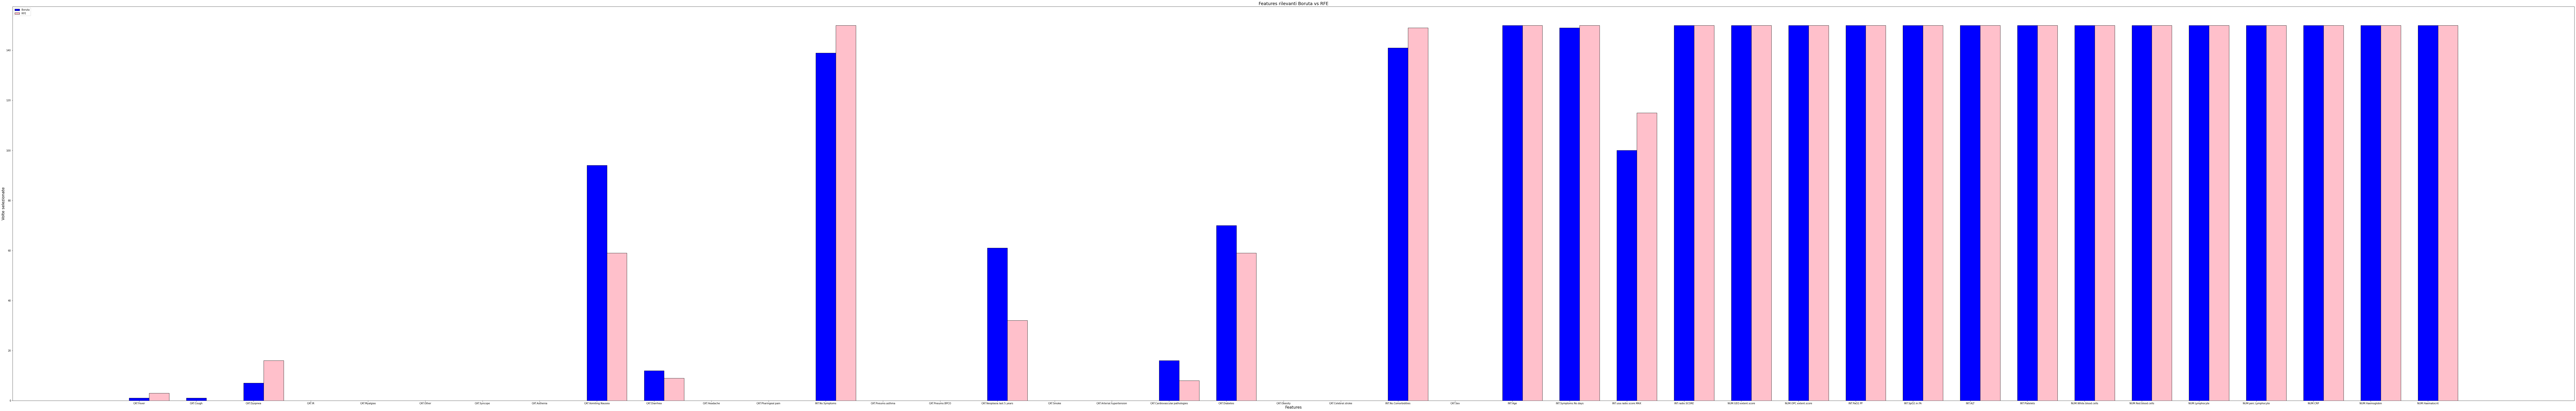

In [31]:

x=features
legend=['Boruta','RFE']
pos = np.arange(len(x))
bar_width = 0.35
y1=contaboruta
y2=contarfe
plt.figure(figsize=(190, 30))
plt.bar(pos,y1,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,y2,bar_width,color='pink',edgecolor='black')
plt.xticks(pos, x)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Volte selezionate', fontsize=16)
plt.title('Features rilevanti Boruta vs RFE',fontsize=18)
plt.legend(legend,loc=2)
plt.show()